# Duplicates, Near Dupliciates, and Statistics

- Generate statistics (like # of documents, etc.)
- Find duplicate documents
- Find near-duplicate documents
- Write out a statistics `yaml` file that is used to give the website this information.

Use a pretty simple algoirthm based on the text vectorization to find duplicate documents.

## Config

In [1]:
n_words_to_check = 1000 # How many words should we be looking at to tell if a document is "similar" to another document

duplicate_cut = 0.98 # How close to 1 do two documents have to be to be duplicates?
updated_cut = 0.9 # How close to 1 do two documents have to be to be updates of each other?

date_of_scan = "September 1, 2020" # When this set of documents was downloaded (and then scanned)

## Setup

In [2]:
from config import text_file_info, extra_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import _check_stop_list

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

stopwords = list(_check_stop_list('english')) + extra_stopwords

## Text Loading and Vectorizing

In [3]:
files_by_area = list(text_file_info())

In [4]:
vectorizer = TfidfVectorizer(input='filename',
                             max_df=0.5, max_features=n_words_to_check,
                             min_df=2,
                             stop_words=stopwords,
                             use_idf=True)

In [5]:
%%time
files_in_order = [f[2] for f in files_by_area]
x = vectorizer.fit_transform(files_in_order)

CPU times: user 3.09 s, sys: 787 ms, total: 3.88 s
Wall time: 10.3 s


In [6]:
n_total_files = len(files_in_order)
n_total_files

1566

## Construct an adjacency matrix

`x` is the list of vectors, one per document. We now need to basically calculate the vector distance ($\sqrt{x_1 x_2}$) between documents represented by vectors $x_1$ and $x_2$. We can do this by doing the transpose of the matrix `x` times itself.

Of course, a document is most similar to itself in this - so the diagonal of this matrix will be 1's.

The basics for this were taken from a [stackoverflow](https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents/8897648#8897648) question.

In [7]:
similarity = (x*x.T).A
np.fill_diagonal(similarity, np.nan)

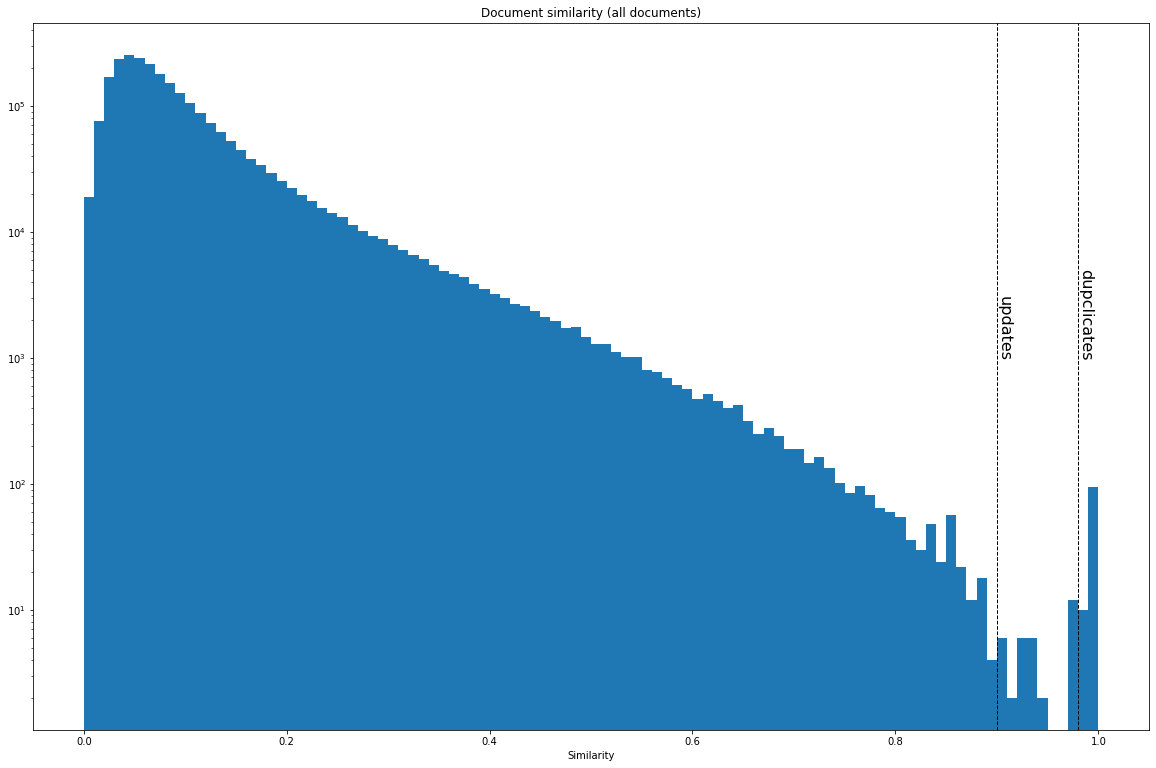

In [8]:
plt.figure(figsize=(20, 13))
plt.hist(similarity.flatten(), bins=100, range=(0,1))
plt.yscale('log')
plt.xlabel('Similarity')
plt.axvline(duplicate_cut, color='k', linestyle='dashed', linewidth=1)
plt.text(duplicate_cut, 1000, 'dupclicates', rotation=270, fontsize=16)
plt.axvline(updated_cut, color='k', linestyle='dashed', linewidth=1)
plt.text(updated_cut, 1000, 'updates', rotation=270, fontsize=16)
_ = plt.title('Document similarity (all documents)')
plt.savefig('../web/assets/images/document_similarity.png')

In [9]:
def make_similarity_df(sim_matrix, files_in_order, index: int):
    'Get the similarity dataframe. index is 0, get back document itself, 1 most similar, 2 second most...'
    similar_index = np.argsort(similarity, axis=1)[:,-1-index]
    similar_score = np.sort(similarity, axis=1)[:,-1-index]

    all_scores = [
        {
            's_score': s_score,
            'f_name': f_name,
            'similar_name': files_in_order[s_index]
        }
        for f_name, s_score, s_index in zip(files_in_order, similar_score, similar_index) 
    ]
    return pd.DataFrame(all_scores)

In [10]:
similar_list = [make_similarity_df(similarity, files_in_order, next_most) for next_most in range(1, 6)]

## Lists of similar documents

In [11]:
def get_documents(sim_matrix):
    '''Return a dictionary with a list of files for each entry that is larger than one.
    '''
    result = {}
    all_found = set()
    for index, line in enumerate(sim_matrix):
        if index not in all_found:
            related = np.nonzero(line)[0]
            if len(related) > 0:
                result[index] = related
                all_found.update(related)
    return result

m_duplicates = similarity > duplicate_cut
m_updates_or_better = similarity > updated_cut
m_updates = m_updates_or_better & ~m_duplicates

duplicates = get_documents(m_duplicates)
updates = get_documents(m_updates)

print(f'Number of duplicates: {len(duplicates)}')
print(f'Number of updates: {len(updates)}')

Number of duplicates: 44
Number of updates: 15


## Plots and lists, 1 by 1

Look at the most similar, then the next most similar, etc.

In [12]:
def plot_and_dump(df, index):
    plt.figure(figsize=(13, 7))
    plt.hist(df.s_score, bins=100, range=(0, 1.0))
    plt.xlabel('Similarity')
    plt.title(f'Document similarity (closest {index} similarity)')
    plt.show()

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df[df.s_score > duplicate_cut].sort_values('s_score'))

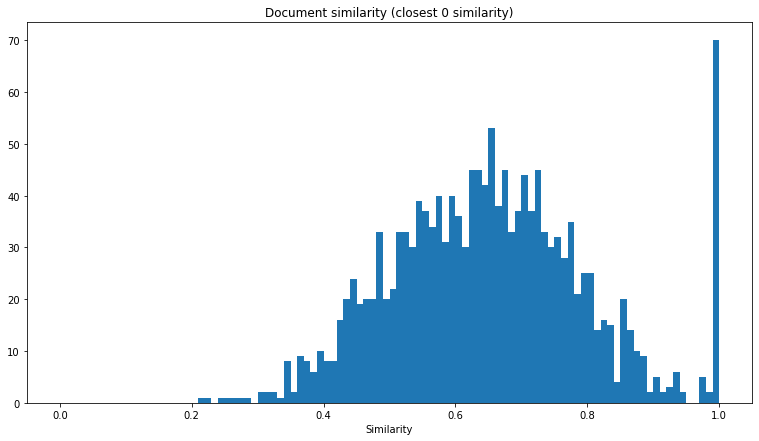

,s_score,f_name,similar_name
1430,0.989321,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...
1429,0.989897,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0-039.txt
105,0.992715,loi-text/AF/SNOWMASS21-AF5_AF0-RF5_RF0_Prebys-...,loi-text/AF/SNOWMASS21-AF5_AF0-RF5_RF0_Prebys2...
107,0.992715,loi-text/AF/SNOWMASS21-AF5_AF0-RF5_RF0_Prebys2...,loi-text/AF/SNOWMASS21-AF5_AF0-RF5_RF0_Prebys-...
1166,0.998244,loi-text/NF/SNOWMASS21-NF0_NF0_Nick_Solomey-00...,loi-text/NF/SNOWMASS21-NF0_NF0_Nick_Solomey-01...
1167,0.998244,loi-text/NF/SNOWMASS21-NF0_NF0_Nick_Solomey-01...,loi-text/NF/SNOWMASS21-NF0_NF0_Nick_Solomey-00...
1421,0.999807,loi-text/RF/SNOWMASS21-RF5_RF0-AF5_AF0_J_Paste...,loi-text/RF/SNOWMASS21-RF5_RF0-AF5_AF0_Pastern...
1423,0.999807,loi-text/RF/SNOWMASS21-RF5_RF0-AF5_AF0_Pastern...,loi-text/RF/SNOWMASS21-RF5_RF0-AF5_AF0_J_Paste...
1318,0.999917,loi-text/NF/SNOWMASS21-NF6_NF2_Kenneth_Long-07...,loi-text/NF/SNOWMASS21-NF6_NF2-EF0_EF0-AF2_AF4...
1302,1.000000,loi-text/NF/SNOWMASS21-NF5_NF4-084.txt,loi-text/NF/SNOWMASS21-NF5_NF4_Baudis-085.txt


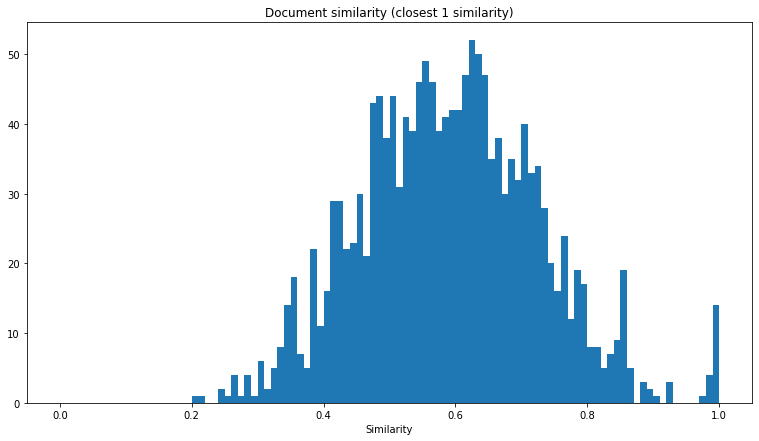

,s_score,f_name,similar_name
1430,0.989289,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0-039.txt
1428,0.989897,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...
1426,0.989897,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0-039.txt,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...
1429,0.989897,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...
1318,0.999917,loi-text/NF/SNOWMASS21-NF6_NF2_Kenneth_Long-07...,loi-text/NF/SNOWMASS21-NF6_NF2-EF0_EF0-AF2_AF4...
1317,0.999917,loi-text/NF/SNOWMASS21-NF6_NF2-EF0_EF0-AF2_AF4...,loi-text/NF/SNOWMASS21-NF6_NF2_Kenneth_Long-07...
1316,0.999917,loi-text/NF/SNOWMASS21-NF6_NF2-EF0_EF0-AF2_AF4...,loi-text/NF/SNOWMASS21-NF6_NF2_Kenneth_Long-07...
1014,1.000000,loi-text/IF/SNOWMASS21-IF2_IF0-CF7_CF3_Tom_Die...,loi-text/IF/SNOWMASS21-IF2_IF0-CF7_CF3-090.txt
1013,1.000000,loi-text/IF/SNOWMASS21-IF2_IF0-CF7_CF3-090.txt,loi-text/IF/SNOWMASS21-IF2_IF0-CF7_CF3_Tom_Die...
15,1.000000,loi-text/AF/SNOWMASS21-AF1_AF0-061.txt,loi-text/EF/SNOWMASS21-EF1_EF0-050.txt


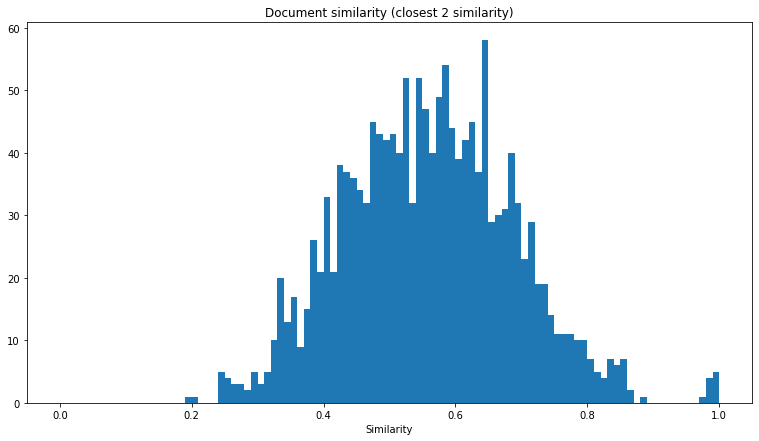

,s_score,f_name,similar_name
1426,0.989289,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0-039.txt,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...
1428,0.989289,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...
1430,0.989289,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...
1429,0.989321,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...,loi-text/RF/SNOWMASS21-RF5_RF0-IF4_IF0_Gianant...
15,1.000000,loi-text/AF/SNOWMASS21-AF1_AF0-061.txt,loi-text/EF/SNOWMASS21-EF1_EF4_Litvinenko-052.txt
70,1.000000,loi-text/AF/SNOWMASS21-AF3_AF6-EF1_EF4_Litvine...,loi-text/AF/SNOWMASS21-AF1_AF0-061.txt
716,1.000000,loi-text/EF/SNOWMASS21-EF0_EF0-AF0_AF0_Vladimi...,loi-text/EF/SNOWMASS21-EF1_EF4_Litvinenko-052.txt
752,1.000000,loi-text/EF/SNOWMASS21-EF1_EF0-050.txt,loi-text/AF/SNOWMASS21-AF1_AF0-061.txt
785,1.000000,loi-text/EF/SNOWMASS21-EF1_EF4_Litvinenko-052.txt,loi-text/AF/SNOWMASS21-AF1_AF0-061.txt


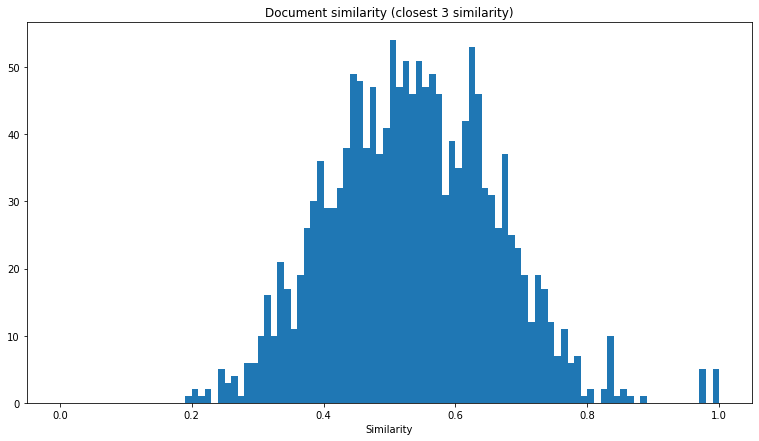

,s_score,f_name,similar_name
15,1.0,loi-text/AF/SNOWMASS21-AF1_AF0-061.txt,loi-text/EF/SNOWMASS21-EF0_EF0-AF0_AF0_Vladimi...
70,1.0,loi-text/AF/SNOWMASS21-AF3_AF6-EF1_EF4_Litvine...,loi-text/EF/SNOWMASS21-EF0_EF0-AF0_AF0_Vladimi...
716,1.0,loi-text/EF/SNOWMASS21-EF0_EF0-AF0_AF0_Vladimi...,loi-text/AF/SNOWMASS21-AF1_AF0-061.txt
752,1.0,loi-text/EF/SNOWMASS21-EF1_EF0-050.txt,loi-text/EF/SNOWMASS21-EF0_EF0-AF0_AF0_Vladimi...
785,1.0,loi-text/EF/SNOWMASS21-EF1_EF4_Litvinenko-052.txt,loi-text/EF/SNOWMASS21-EF0_EF0-AF0_AF0_Vladimi...


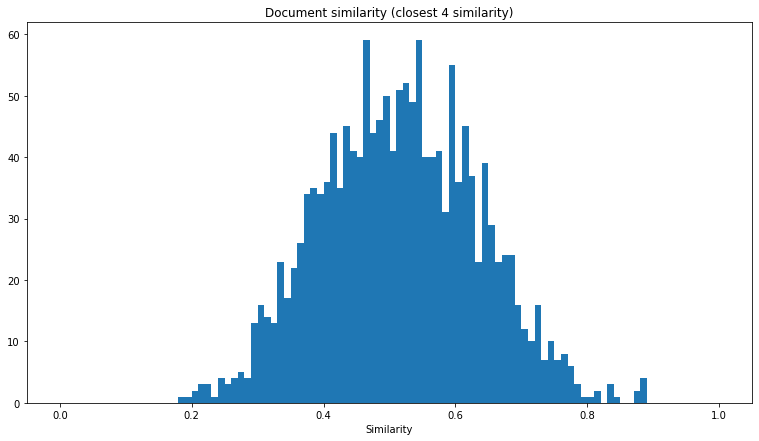

,s_score,f_name,similar_name


In [13]:
for index, df in enumerate(similar_list):
    plot_and_dump(df, index)

And the total number of duplicates by this criteria:

In [14]:
sum([len(df[df.s_score > duplicate_cut]) for df in similar_list])

128

## Write out the yaml datafile

In [15]:
def f_name(f):
    return Path(f).stem

def f_area(f):
    return Path(f).parent.name

def f_link(f):
    return f'https://www.snowmass21.org/docs/files/summaries/{f_area(f)}/{f_name(f)}.pdf'

def dump_related_info(info, data):
    for k in info:
        data.write(f'  - main_name: {f_name(files_in_order[k])}\n')
        data.write(f'    main_link: {f_link(files_in_order[k])}\n')
        data.write('    duplicates:\n')
        for d in info[k]:
            data.write(f'    - name: {f_name(files_in_order[d])}\n')
            data.write(f'      link: {f_link(files_in_order[d])}\n')
    
with open('../web/_data/stats.yaml', 'w') as data:
    data.write(f'total_documents: {n_total_files}\n')
    data.write(f'unique_documents: {n_total_files-len(duplicates)}\n')
    data.write(f'clean_documents: {n_total_files-len(duplicates)-len(updates)}\n')
    data.write(f'date_of_download: {date_of_scan}\n')
    data.write('duplicates:\n')
    dump_related_info(duplicates, data)
    data.write('updates:\n')
    dump_related_info(updates, data)
